# Imports


In [1]:
import random
import time
import pprint
from operator import itemgetter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import data

In [2]:
raw_data6 = pd.read_csv('data/scenario6.labeled', delimiter='\s+', low_memory=False)

In [3]:
def parse_data(raw):
    data = raw
    data['Date'] = data['Date'].map(str) + " " + data['flow']

    src_ip_port = data['Prot'].map(str).str.split(':', n=1, expand = True)
    dst_ip_port = data['IP'].map(str).str.split(':', n=1, expand = True)
    data['src_ip'] = src_ip_port[0]
    data['src_port'] = src_ip_port[1]
    data['dst_ip'] = dst_ip_port[0]
    data['dst_port'] = dst_ip_port[1]

    data.drop(['flow', 'Src','Packets', 'Bytes', 'Flows', 'Prot', 'IP', 'Label', 'Labels'], axis=1, inplace=True)
    data.rename(columns={'start':'duration', 'Date':'start','Durat':'protocol', 'Addr:Port':'flags', 'Dst':'tos', 'IP.1':'packets', 'Addr:Port.1':'bytes', 'Flags':'flows', 'Tos':'label'}, inplace=True)
    data.sort_values(by='start', inplace=True)
    
    return data

In [4]:
data6 = parse_data(raw_data6)

# Sampling

### Obtain IP addresses to sample

In [5]:
# Select the applicable rows
df = data6
infected_ip = '147.32.84.165'

src_rows_with_infected_ip = df[df['src_ip'] == infected_ip]
dst_df = src_rows_with_infected_ip['dst_ip']
from_infected = dst_df.values

dst_rows_with_infected_ip = df[df['dst_ip'] == infected_ip]
src_df = dst_rows_with_infected_ip['src_ip']
to_infected = src_df.values

nr_of_unique_ips = len(np.unique(from_infected))

print(f'IP {infected_ip} sends packets to {nr_of_unique_ips} unique IP addresses.')    

IP 147.32.84.165 sends packets to 1582 unique IP addresses.


### Reservoir Sampling


Estimate the distribution over the other IP_addresses, what are the 10 most frequent values?
Write code for RESERVOIR sampling, use it to estimate the distribution in one pass (no need to
actually stream the data, you may store it in memory, or run every file separately, but do store
and load the intermediate results). Use a range of reservoir sizes. What are the 10 most frequent
IP-addresses and their frequencies when sampled? Use the theory to explain any approximation
errors you observe

In [6]:
# random_replace replaces a random element in sample with ip
def random_replace(sample, ip):
    r = random.randint(0, len(sample) - 1)
    sample[r] = ip    

# reservoir_sample performs reservoir sampling on the stream
def reservoir_sample(stream, reservoir_size):
    sample = []
    for i, ip in enumerate(stream):
        if i < reservoir_size:
            # Fill sample first
            sample.append(ip)
        else:
            # Probability that the next item should be sampled
            proba = reservoir_size / (i + 1)
            # Draw random number, if smaller than proba it should be sampled
            r = random.random()
            if r <= proba:
                # Element should be sampled
                random_replace(sample, ip)
    return sample

# aggregate counts the occurences per IP
def aggregate(ips, return_n_best=None):
    counts = {}
    for ip in ips:
        if ip not in counts:
            counts.update({ip: 0})
        counts[ip] += 1
    if return_n_best is None:
        return counts
    else:
        counts = counts.items()
        return sorted(counts, key=itemgetter(1), reverse=True)[:return_n_best]    

# overlap computes the number of elements which are estimated 'correctly'
def overlap(real, estimate):
    real = set([ip for (ip, _) in real])
    estimate = [ip for (ip, _) in estimate]
    count = 0
    for e in estimate:
        if e in real:
            count +=1            
    return count

# Create a largest-first distribution from the number of occurences per IP
def distribution_from_counts_dict(d: dict):
    counts_list = [v for v in d.values()]
    return sorted(counts_list, reverse=True)

[('91.212.135.158', 36), ('64.59.134.8', 17), ('74.205.4.13', 14), ('65.55.92.168', 12), ('65.55.92.136', 12), ('65.55.37.72', 12), ('216.32.180.22', 10), ('65.55.37.120', 9), ('65.54.188.110', 9), ('24.71.223.11', 9)]


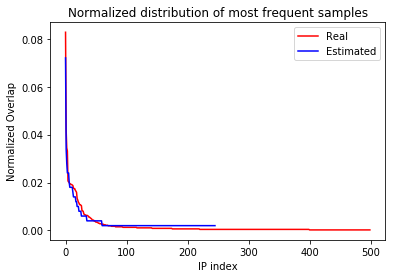

In [7]:
reservoir_size = 500

# Real distribution
real = aggregate(from_infected)
real_distribution = distribution_from_counts_dict(real)[:reservoir_size]
real_total = sum(real_distribution)
real_normalized = [e/real_total for e in real_distribution]

sample = reservoir_sample(from_infected, reservoir_size)
estimated = aggregate(sample)

# We are interested in the distribution, are the normalized values ditributed as in the real sample?
estimated_distribution = distribution_from_counts_dict(estimated)
estimated_total = sum(estimated_distribution)
estimated_normalized = [e/estimated_total for e in estimated_distribution]

print(aggregate(sample, 10))

# Plot the distribution
plt.figure()
plt.plot(real_normalized, label='Real', color='red')
plt.plot(estimated_normalized , label='Estimated', color='blue')
plt.xlabel('IP index')
plt.ylabel('Normalized Overlap')
plt.title('Normalized distribution of most frequent samples')
plt.legend()
plt.show()

In [8]:
best_n = 10
# To get a nice estimate per reservoir size, we need to repeat this experiment very often.
n_runs = 500
reservoir_sizes = [1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700]

# Calculate the real 10 most occurring values
real = aggregate(from_infected, best_n)
print(f'Real {best_n} most frequent values:')
pprint.pprint(real)

# Calculate the sampled 10 most occurring values
sample = reservoir_sample(from_infected, 300)
estimated = aggregate(sample, best_n)
print(f'\nEstimated {best_n} most frequent values:')
pprint.pprint(estimated)

print('Overlap between real and estimate:', overlap(real, estimated))
ip_overlaps = []

# Print the execution times, calculate the average overlaps
for reservoir_size in reservoir_sizes:
    ip_overlap = 0
    t = time.time()
    for _ in range(n_runs):
        sample = reservoir_sample(from_infected, reservoir_size)
        estimated = aggregate(sample, best_n)
        ip_overlap += overlap(real, estimated)
    ip_overlap /= n_runs
    ip_overlaps.append(ip_overlap)
    # For the execution time per run:
    print((time.time() - t)/n_runs)

Real 10 most frequent values:
[('91.212.135.158', 384),
 ('64.59.134.8', 194),
 ('24.71.223.11', 160),
 ('216.32.180.22', 154),
 ('65.55.37.72', 96),
 ('65.55.37.88', 94),
 ('65.55.92.136', 93),
 ('65.55.92.168', 90),
 ('65.55.92.152', 90),
 ('202.108.252.141', 89)]

Estimated 10 most frequent values:
[('91.212.135.158', 22),
 ('24.71.223.11', 11),
 ('65.54.188.110', 8),
 ('65.55.37.88', 7),
 ('65.55.92.152', 7),
 ('64.59.134.8', 7),
 ('206.46.232.11', 6),
 ('65.55.92.168', 6),
 ('72.14.213.27', 5),
 ('202.108.252.141', 4)]
7


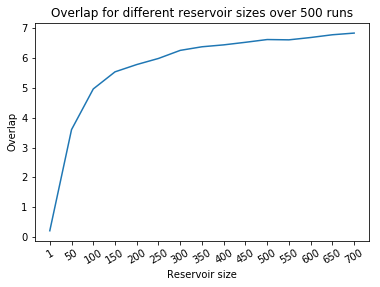

In [9]:
# Plot the (on average) growing overlap when increasing the reservoir size
plt.figure()
plt.plot(ip_overlaps)
plt.xticks(np.arange(len(reservoir_sizes)), reservoir_sizes, rotation=30)
plt.xlabel('Reservoir size')
plt.ylabel('Overlap')
plt.title(f'Overlap for different reservoir sizes over {n_runs} runs')
plt.show()

# Sketching

Build code for computing a COUNT-MIN sketch, play with different heights and widths for the Count-Min sketch matrix. Compare it to the RESERVOIR sampling strategy. Is it more spaceefficient/accurate? What about run-time? Use the theory to explain any differences you observe.

### COUNT-MIN Sketch

In [10]:
# This function returns a (semi)unique hash function. 
# A new hash function is created based on the built-in hash function,
# but with a seeded random mask. Based on a stackoverflow code snippet.
# source: https://stackoverflow.com/questions/2255604/hash-functions-family-generator-in-python
def hash_function(n, w):
    random.seed(n)
    mask = random.getrandbits(64)
        
    def myhash(x):
        return (hash(x) ^ mask) % w
    
    return myhash

# Create a matrix with counts
def count_min_sketch(stream, w, d):
    cm = np.zeros((d, w), dtype=int)
    hash_functions = [hash_function(i, w) for i in range(d)]
    for e in stream:
        for i, hi in enumerate(hash_functions):
            v = hi(e)
            cm[i, v] += 1
    return cm, hash_functions

# Estimate occurence of a list of ips
def estimate_occurences(cm, hash_functions, ips):
    res = []
    for ip in ips:
        min_occurence = None
        for i, hi in enumerate(hash_functions):
            v = cm[i, hi(ip)]
            if min_occurence is None or min_occurence > v:
                min_occurence = v
        res.append((ip, min_occurence))
    return res

In [11]:
stream = from_infected
# 50 runs takes a long time! Do not execute when not necessary ;)
n_runs = 50

# width
w = 50
# n_hash_functions, depth/height
d = 5

# Return matrix with counts and the used hash functions
cm, hs = count_min_sketch(stream, w, d)
# ips = [ip for (ip, occ) in real]
unique_ips = np.unique(from_infected)
estimates = sorted(estimate_occurences(cm, hs, unique_ips), key=itemgetter(1), reverse=True)
print(estimates[:10])
print(overlap(real, estimates[:10]))

for w in [1, 10, 50, 100, 1000]:
    for d in [1, 5, 10, 50, 100, 1000]:
        t = time.time()
        for _ in range(n_runs):
            cm, hs = count_min_sketch(stream, w, d)
            unique_ips = np.unique(from_infected)
            estimates = sorted(estimate_occurences(cm, hs, unique_ips), key=itemgetter(1), reverse=True)
    #         print(f'{w}, {d}, {overlap(real, estimates[:10])}, {estimates[:10][0][1]}')
        print((time.time() - t)/n_runs)

print(real)

[('91.212.135.158', 426), ('24.71.223.11', 255), ('64.59.134.8', 224), ('216.32.180.22', 188), ('65.55.37.88', 169), ('65.55.37.72', 168), ('204.232.236.212', 164), ('202.102.13.154', 139), ('136.158.6.42', 137), ('202.108.252.141', 134)]
7
0.00926455020904541
0.026080431938171385
0.05868424415588379
0.2370791721343994
0.4369898796081543
4.300423398017883
0.011364321708679199
0.030443758964538575
0.05284379482269287
0.22588067054748534
0.4474711608886719
4.304728088378906
0.008931145668029786
0.026978321075439453
0.0527415132522583
0.2250540018081665
0.42387556076049804
4.512283625602723
0.009304642677307129
0.028254928588867186
0.05020354270935059
0.22498541355133056
0.4266363000869751
4.617710700035095
0.008548951148986817
0.026053214073181154
0.04736437797546387
0.23613772869110108
0.46424129486083987
4.83473614692688
[('91.212.135.158', 384), ('64.59.134.8', 194), ('24.71.223.11', 160), ('216.32.180.22', 154), ('65.55.37.72', 96), ('65.55.37.88', 94), ('65.55.92.136', 93), ('65.55.